In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall
import torch.nn.functional as F


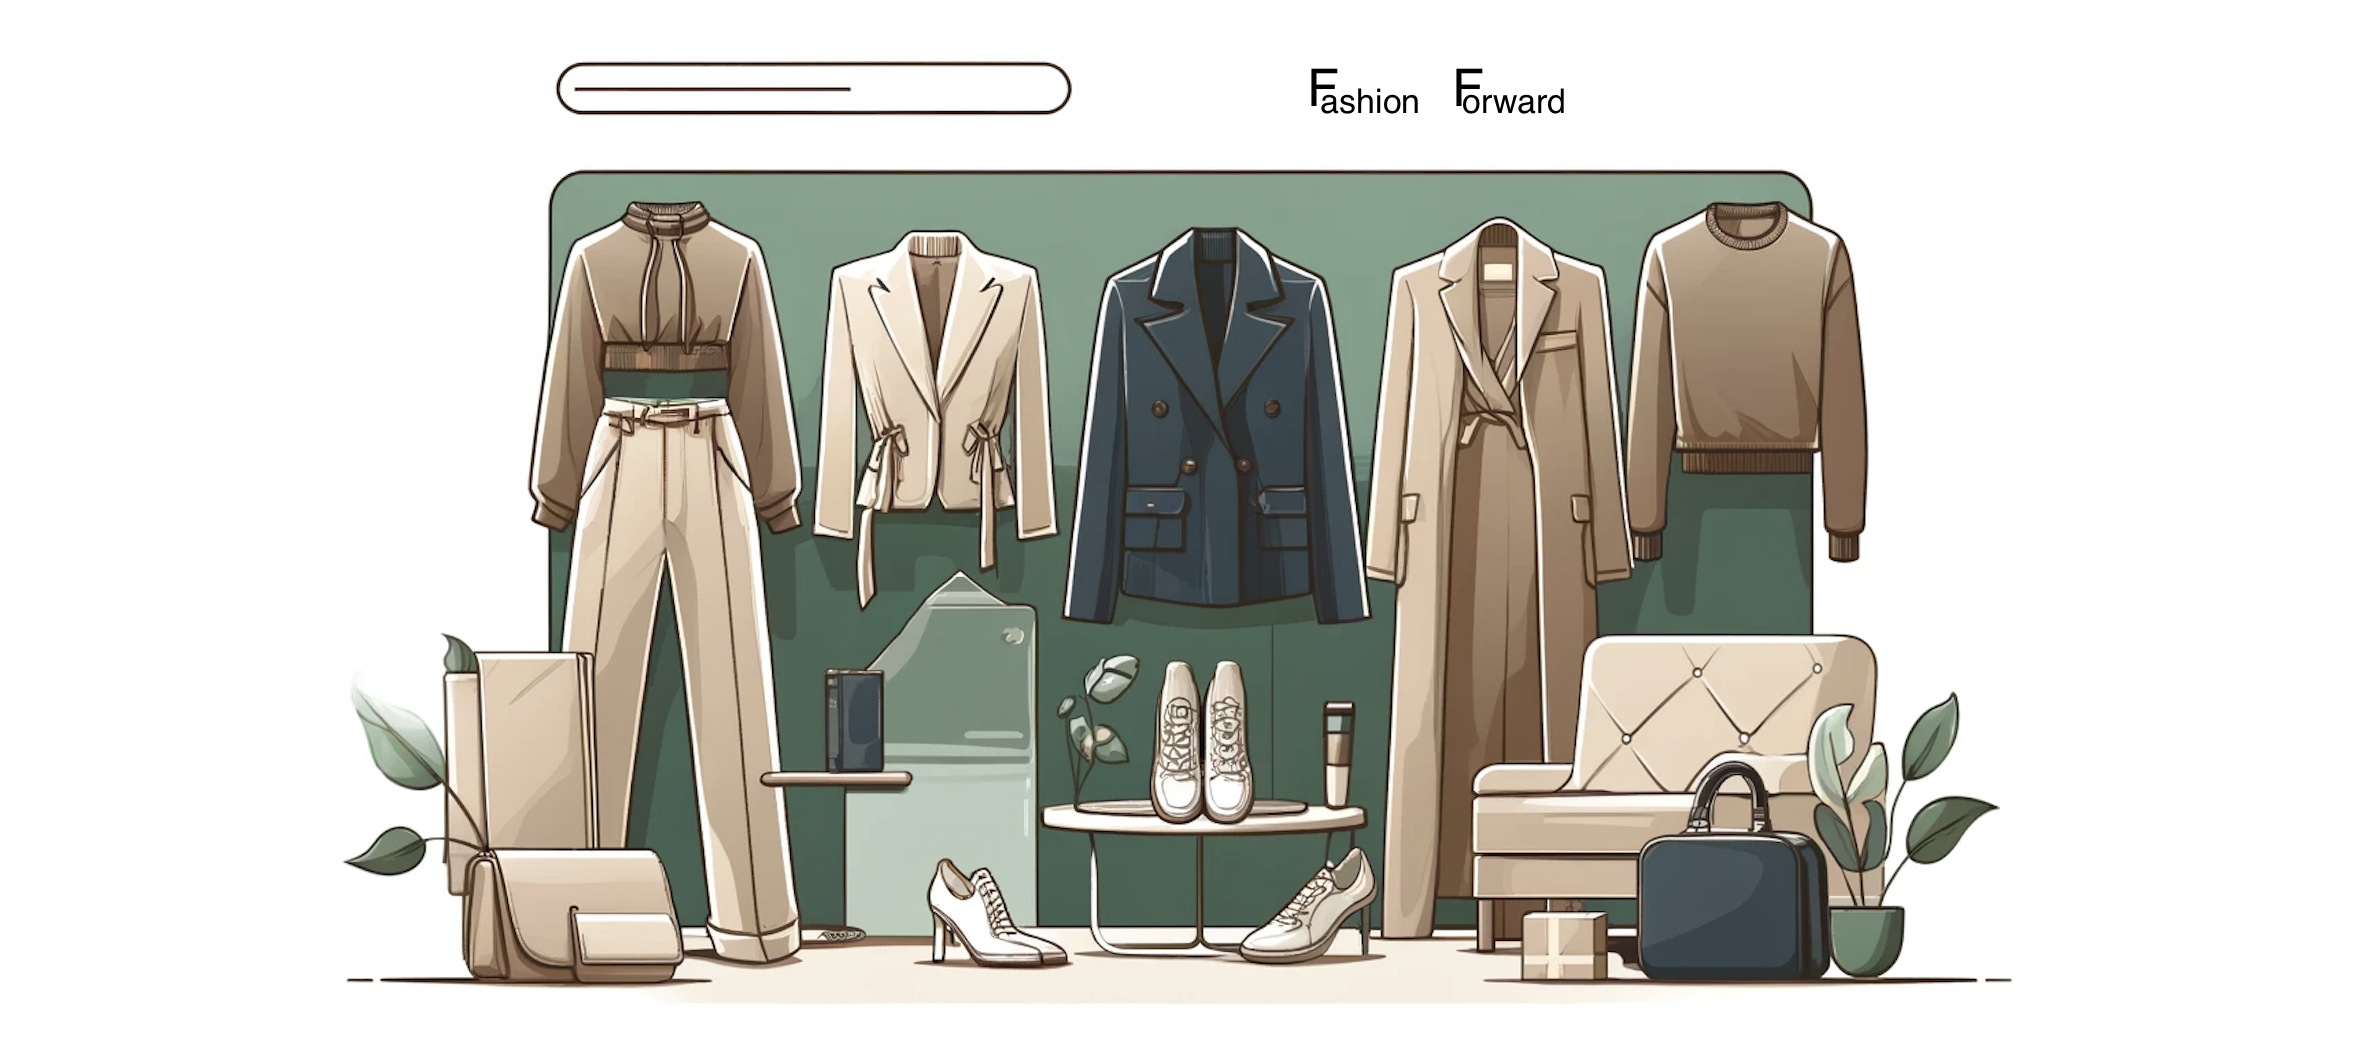

Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [3]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [9]:
dataloader_train = DataLoader(train_data, batch_size = 1, shuffle = True)
dataloader_test = DataLoader(test_data, batch_size =1, shuffle = True)

In [21]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size =3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size =3, stride = 1, padding=1)
        self.fc1 = nn.Linear(64*7*7, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        return x
    

In [17]:
classes = train_data.classes
print (classes)
num_classes = len(train_data.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [32]:
model = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(dataloader_train)}')

print('Finished Training')

Epoch 1, Loss: 0.3720788739523337
Epoch 2, Loss: 0.28482364768953666
Finished Training


In [77]:
from torchmetrics import Accuracy, Recall, Precision
metric_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
metric_precision = Precision(task='multiclass', num_classes=num_classes, average=None)
metric_recall = Recall(task="multiclass", num_classes=num_classes, average=None)
model.eval()
label_test = []
preds_list = []
with torch.no_grad():
    for images, labels in dataloader_test:
        label_test.extend(labels.tolist())
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        preds_list.extend(preds.tolist())
        metric_precision(preds, labels)
        metric_recall(preds, labels)
        metric_accuracy(preds, labels)
    
accuracy = metric_accuracy.compute().item()
precision = metric_precision.compute().tolist()
recall = metric_recall.compute().tolist()

In [78]:
import pandas as pd
evaluation = pd.DataFrame()
evaluation['Clothes'] = classes
evaluation['Accuracy'] = accuracy
evaluation['Precision'] = precision
evaluation['Recall'] = recall

In [79]:
evaluation

,Clothes,Accuracy,Precision,Recall
0,T-shirt/top,0.8947,0.832517,0.850
1,Trouser,0.8947,0.992908,0.980
2,Pullover,0.8947,0.801126,0.854
3,Dress,0.8947,0.879728,0.907
4,Coat,0.8947,0.797563,0.851
5,Sandal,0.8947,0.983952,0.981
6,Shirt,0.8947,0.766169,0.616
7,Sneaker,0.8947,0.958251,0.964
8,Bag,0.8947,0.960707,0.978
9,Ankle boot,0.8947,0.963111,0.966


In [69]:
def preview_image(dataset, index):
    """
    Preview an image from the FashionMNIST dataset.
    
    Parameters:
    - dataset: The FashionMNIST dataset.
    - index: Index of the image to preview.
    """
    image, label = dataset[index]
    image = image.squeeze()  # remove the channel dimension

    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {classes[label]}")
    plt.show()

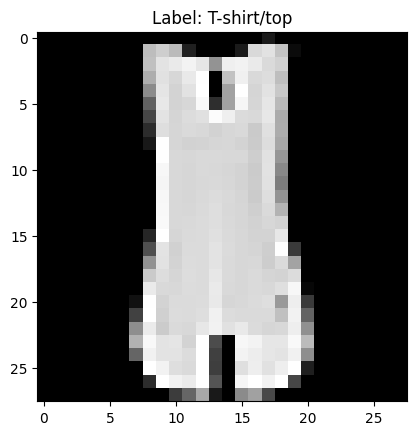

In [70]:
preview_image(train_data,4)

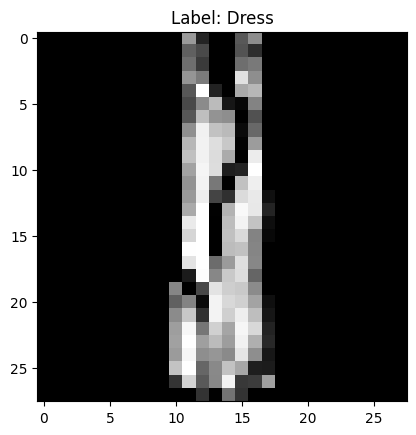

In [71]:
preview_image(test_data, 32)

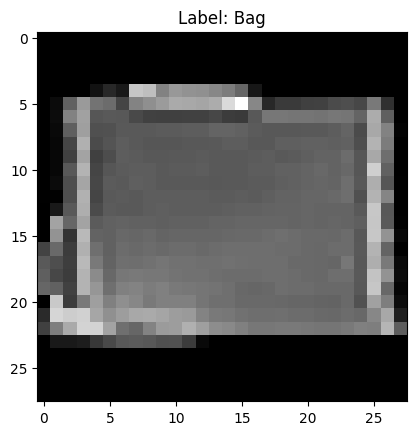

In [73]:
preview_image(test_data, 105)

In [88]:
#Comparing prediction and actual values
pred_df = pd.DataFrame()
pred_df['Actual'] = label_test
pred_df['Prediction'] = preds_list


In [94]:
number_to_class = {i: classes[i] for i in range(10)}

# Replace the numbers with the corresponding class names in both columns
pred_df['Actual'] = pred_df['Actual'].map(number_to_class)
pred_df['Prediction'] = pred_df['Prediction'].map(number_to_class)

# Display the updated DataFrame
pred_df

,Actual,Prediction
0,Sneaker,Sneaker
1,Sandal,Sandal
2,Sneaker,Sneaker
3,Coat,Dress
4,Shirt,Shirt
...,...,...
9995,Shirt,Shirt
9996,Dress,Dress
9997,Sandal,Sandal
9998,Coat,Coat
